In [21]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import keras_ocr
import os
import io
import cv2 

from google.cloud import vision
from pytesseract import Output
from pytesseract import pytesseract as pt
from PIL import Image, ImageDraw
from glob import glob

## 검증용 데이터셋 준비

In [11]:
fold_path = os.getenv('HOME')+'/aiffel/ocr_python/card/'
os.listdir(fold_path)

['StudentID_15.jpeg',
 'StudentID_7.jpeg',
 'StudentID_8.jpeg',
 'StudentID_16.jpeg',
 'images.jpeg',
 'StudentID_18.jpeg',
 'StudentID_12.jpeg',
 'card_1.png',
 'StudentID_14.jpeg',
 'images (3).jpeg',
 'StudentID_11.jpeg',
 'StudentID_13.jpeg',
 'images (6).jpeg',
 'images (1).jpeg',
 'StudentID_20.jpeg',
 'images (4).jpeg',
 'StudentID_17.jpeg',
 'images (5).jpeg',
 'images (2).jpeg',
 'StudentID_19.jpeg']

In [12]:
# def changeName(path, cName):
#     i = 1
#     for filename in os.listdir(path):
#         os.rename(path+filename, path+str(cName)+'_'+str(i)+'.jpeg')
#         i += 1

In [13]:
changeName(fold_path, 'Student')

images_path = glob(fold_path+'*.jpeg')
images_path

['/home/aiffel0042/aiffel/ocr_python/card/Student_1.jpeg',
 '/home/aiffel0042/aiffel/ocr_python/card/Student_11.jpeg',
 '/home/aiffel0042/aiffel/ocr_python/card/Student_15.jpeg',
 '/home/aiffel0042/aiffel/ocr_python/card/Student_6.jpeg',
 '/home/aiffel0042/aiffel/ocr_python/card/Student_18.jpeg',
 '/home/aiffel0042/aiffel/ocr_python/card/Student_14.jpeg',
 '/home/aiffel0042/aiffel/ocr_python/card/Student_10.jpeg',
 '/home/aiffel0042/aiffel/ocr_python/card/Student_17.jpeg',
 '/home/aiffel0042/aiffel/ocr_python/card/Student_16.jpeg',
 '/home/aiffel0042/aiffel/ocr_python/card/Student_3.jpeg',
 '/home/aiffel0042/aiffel/ocr_python/card/Student_7.jpeg',
 '/home/aiffel0042/aiffel/ocr_python/card/Student_20.jpeg',
 '/home/aiffel0042/aiffel/ocr_python/card/Student_13.jpeg',
 '/home/aiffel0042/aiffel/ocr_python/card/Student_19.jpeg',
 '/home/aiffel0042/aiffel/ocr_python/card/Student_8.jpeg',
 '/home/aiffel0042/aiffel/ocr_python/card/Student_5.jpeg',
 '/home/aiffel0042/aiffel/ocr_python/card/Stud

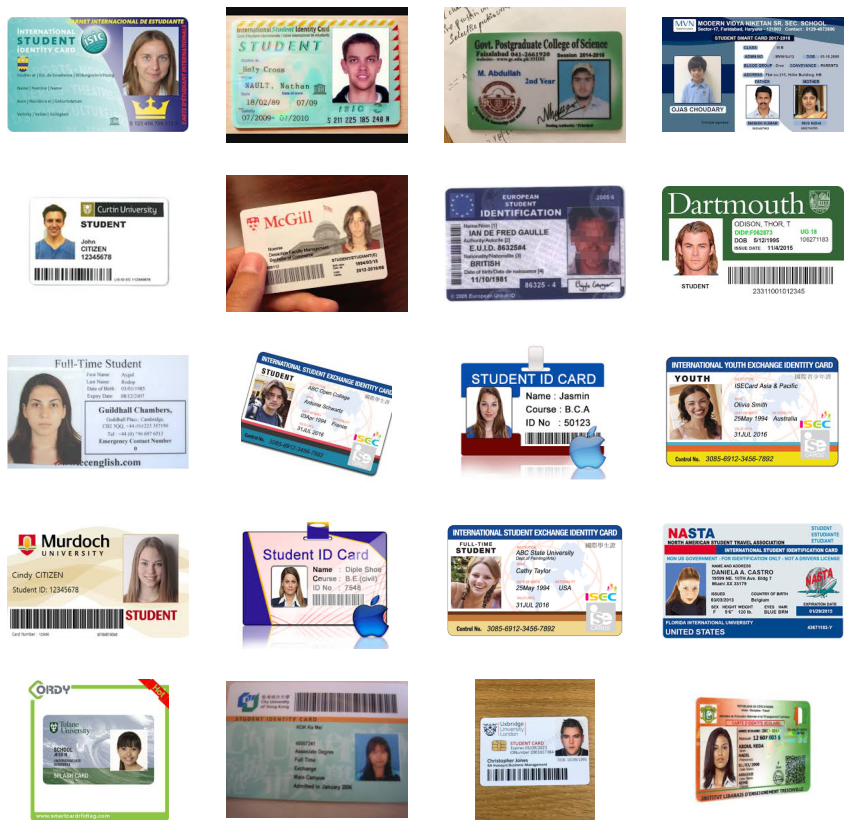

In [14]:
plt.figure(figsize=(15, 15))

for idx, image in enumerate(images_path):
    plt.subplot(5, 4, idx+1)
    im=img.imread(image)
    plt.imshow(im)
    plt.axis('off')

위의 이미지들은 학생증 자동인식 기능이라는 서비스를 만들기 위한 데이터셋이다. 학생증을 식별하기 위해 중요한 데이터가 여러가지이지만, 대표적으로 뽑아보자면.
1. 학생증 번호 (학번)
2. 학생 이름
3. 학교, 전공 이름
4. 기타
가 있을 것이다.  

위의 데이터를 검출하기 위해서는 OCR기능이 필요하다. 그 중 세 가지 OCR (Google OCR API, keras-ocr, Tesseract)을 활용해보고 데이터가 잘 검출되는지 테스트 해볼 것이다.

## OCR API

In [15]:
def draw_boxes(image, bounds, color):
    """Draw a border around the image using the hints in the vector list."""
    draw = ImageDraw.Draw(image)

    for bound in bounds:
        draw.polygon([
            bound.vertices[0].x, bound.vertices[0].y,
            bound.vertices[1].x, bound.vertices[1].y,
            bound.vertices[2].x, bound.vertices[2].y,
            bound.vertices[3].x, bound.vertices[3].y], None, color)
    return image

In [16]:
def detect_text(path):
    """Detects text in the file."""
    text_dec = []
    bounds = []
    client = vision.ImageAnnotatorClient()
    
    with io.open(path, 'rb') as image_file:
        content = image_file.read()
    
    s = os.path.splitext(path)
    s = os.path.split(s[0])
    name = s[1]
    
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations

    for text in texts:
        text_dec.append(text.description.replace('\n',''))
        vertices = text.bounding_poly
        bounds.append(vertices)
    
    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))
        
    return name, text_dec, bounds

In [17]:
# 다운받은 인증키 경로가 정확하게 지정되어 있어야 합니다. 
!ls -l $GOOGLE_APPLICATION_CREDENTIALS

ocr_img = []
ocr_dict = {}
# 입력 이미지 경로를 지정해 주세요.
path = '/home/aiffel0042/aiffel/ocr_python/card/card_3.jpeg'

# # 위에서 정의한 OCR API 이용 함수를 호출해 봅시다.
for path in images_path:
    name, text_dec, bounds = detect_text(path)
    ocr_dict[name] = text_dec
    image = Image.open(path)
    draw_boxes(image, bounds, 'red')
    ocr_img.append(image)

-rw-r--r-- 1 aiffel0042 aiffel0042 2346 10월  7 10:41 /home/aiffel0042/aiffel/ocr_python/my_google_api_key.json


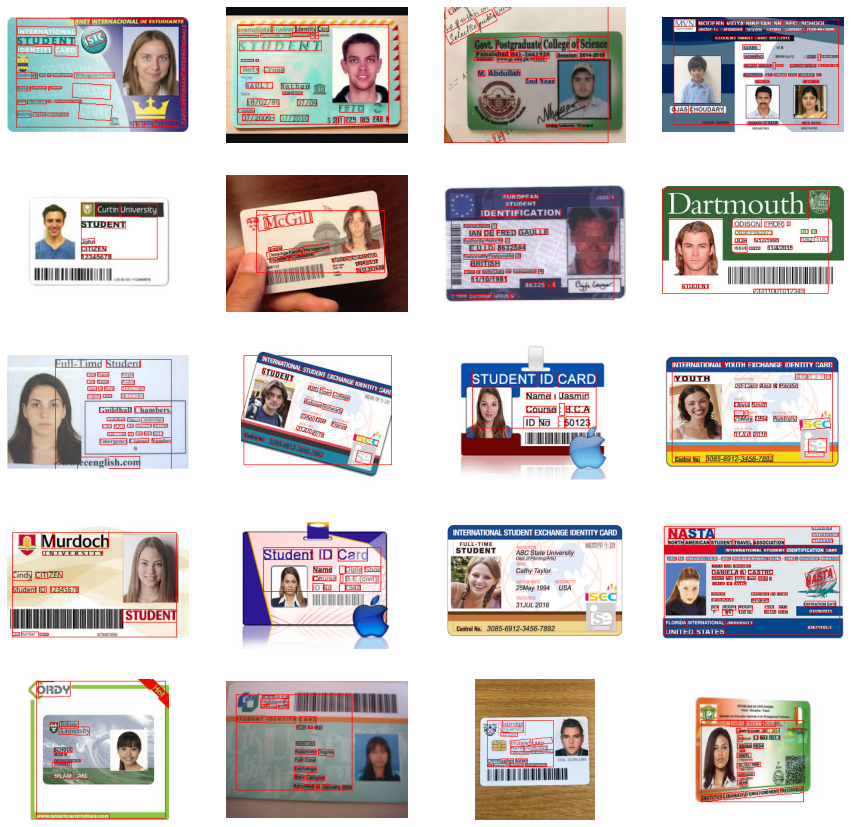

In [18]:
plt.figure(figsize=(15, 15))

for idx, img in enumerate(ocr_img):
    plt.subplot(5, 4, idx+1)
    plt.imshow(img)
    plt.axis('off')

첫 번째 사용한 기술은 Google의 OCR API 기술이다. 구글은 여러가지 이미지 관련 클라우드 서비스를 제공하고 있다. https://console.cloud.google.com/ 에 접속해서 사용 권한을 얻고 JSON파일을 가져오면 쉽게 사용이 가능하다.   

<br>
사용 결과, 준수한 성능을 보이고 있다. 빨간색 박스가 글씨를 제대로 검출했다는 지표인데 대부분 올바르게 검출이 잘되었다. 하지만 15번째 사진은 어째서인지 검출이 잘 되지 않았다. 그래도 이정도면 괜찮은 성적이다. 

## keras-ocr

In [19]:
# keras-ocr will automatically download pretrained
# weights for the detector and recognizer.
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /home/aiffel0042/.keras-ocr/craft_mlt_25k.h5
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Looking for /home/aiffel0042/.keras-ocr/crnn_kurapan.h5


In [47]:
images = [ keras_ocr.tools.read(im) for im in images_path]
predictions = [pipeline.recognize([im]) for im in images_path]

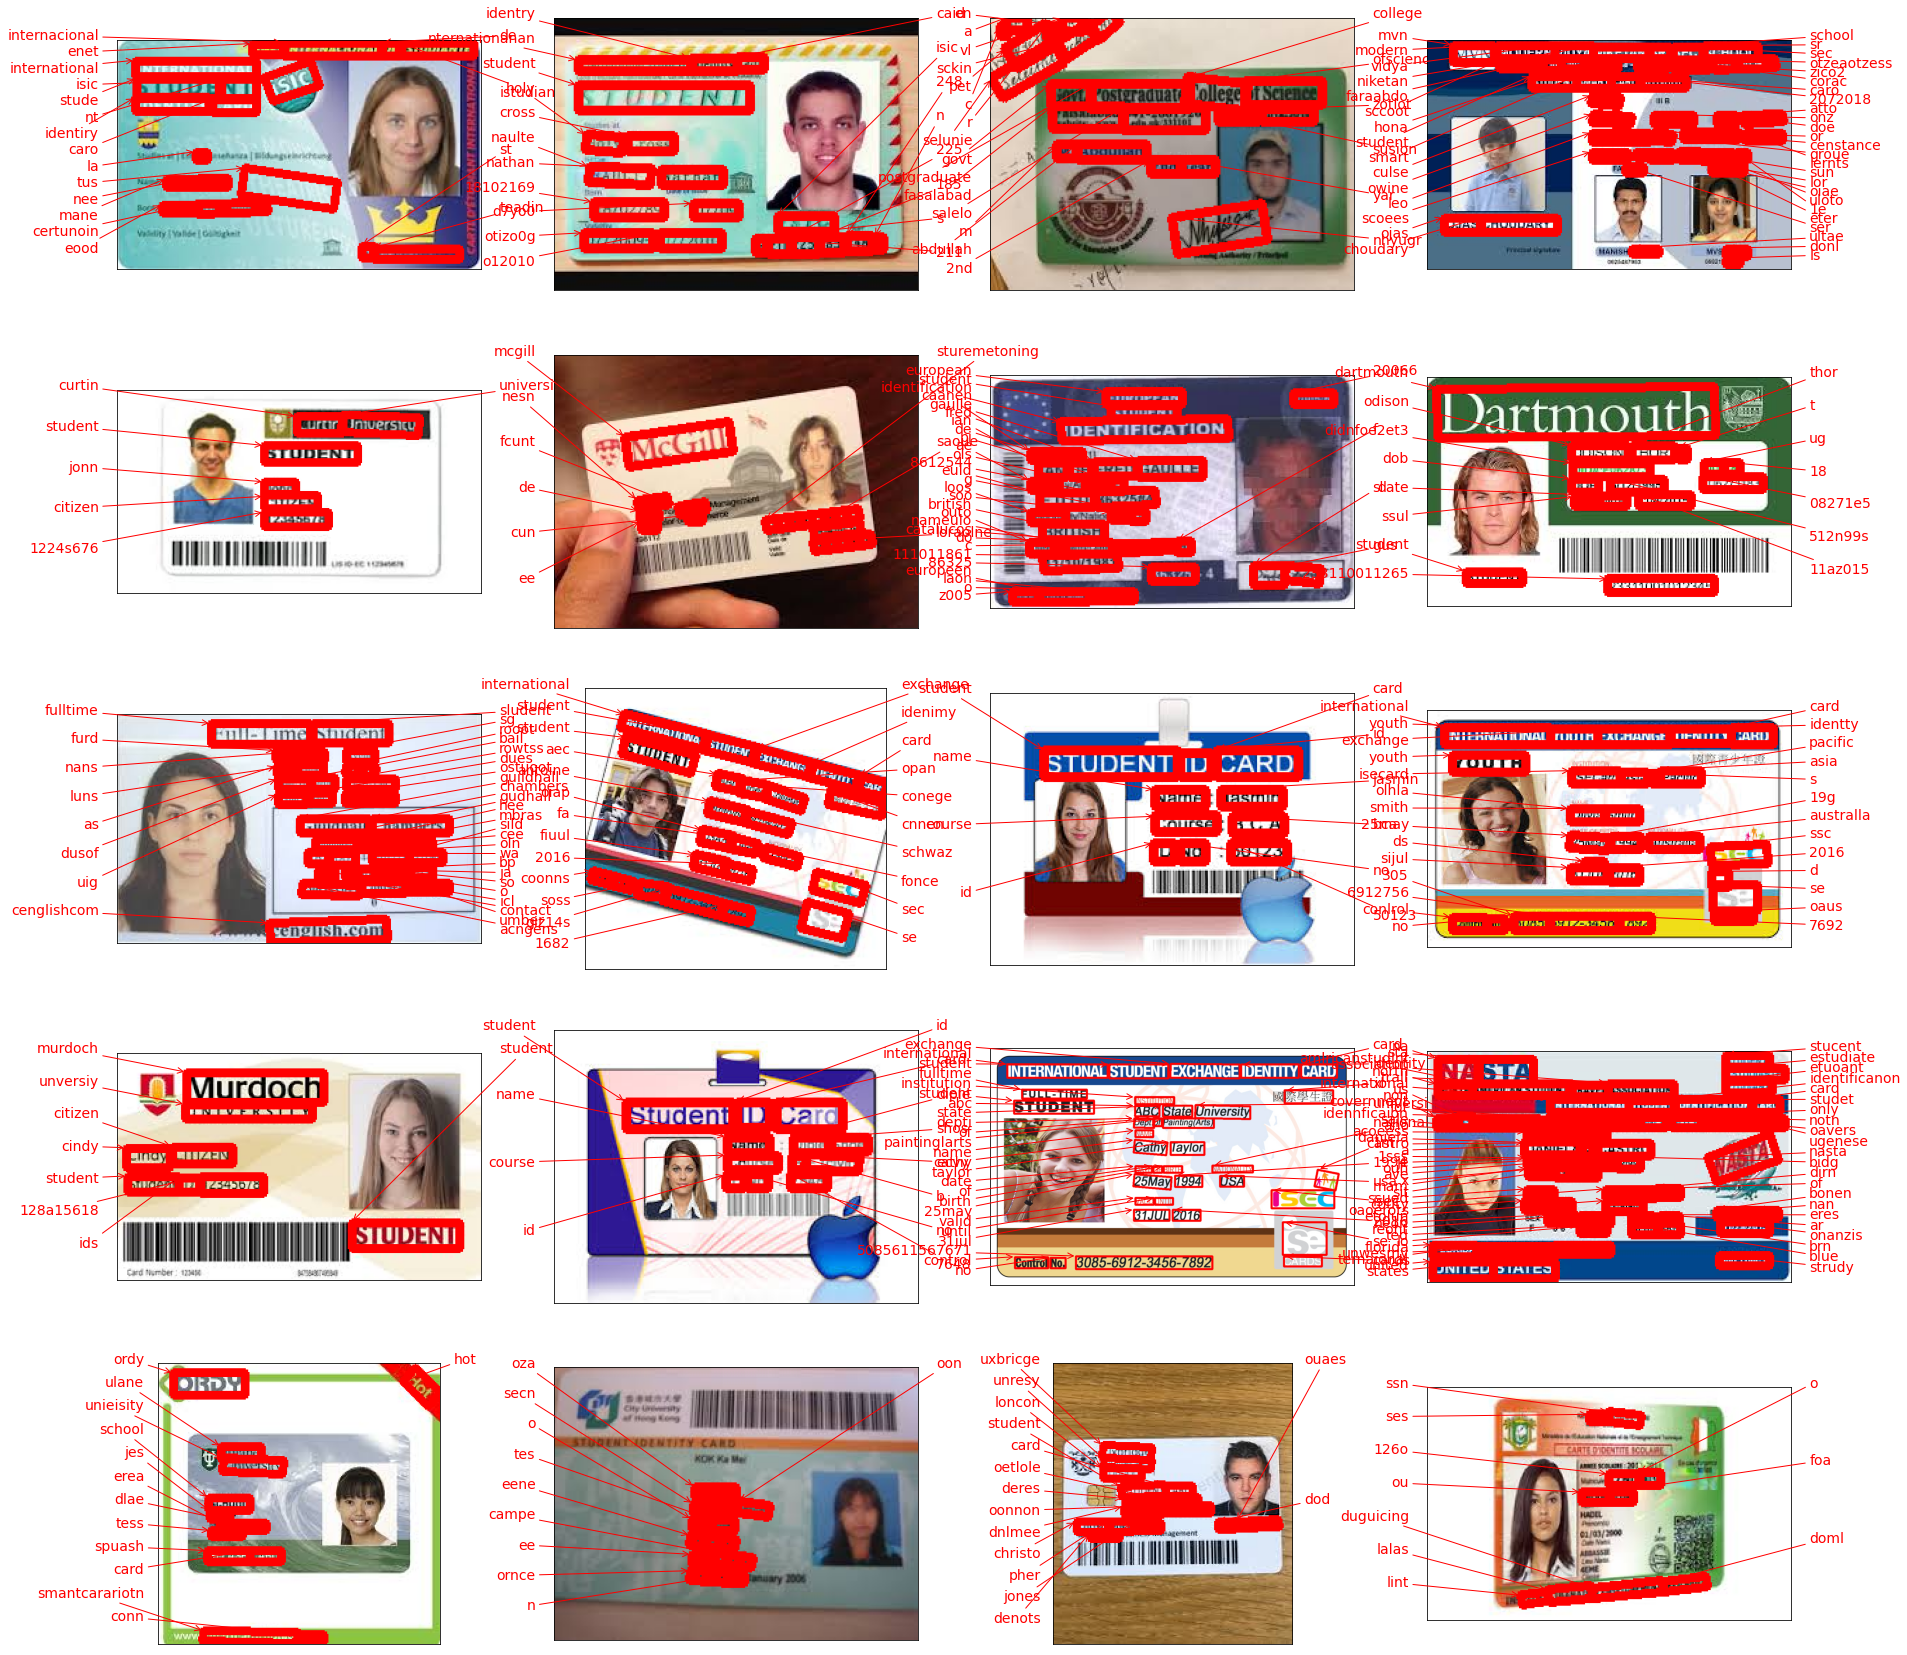

In [46]:
fig, axs = plt.subplots(5, 4, figsize=(30, 30))

for a in range(len(axs)):
    for b in range(len(axs[a])):
        keras_ocr.tools.drawAnnotations(image=images[4*a+b], 
                                    predictions=predictions[4*a+b][0], ax=axs[a,b])

다음 사용해본 기술은 keras-ocr이다. keras-ocr은 텐서플로우의 케라스 API를 기반으로 이미지 속 문자를 읽는 End-to-End OCR을 할 수 있게 해준다. 검출 모델로는 CRAFT를 사용하고, 인식 모델로는 CRNN을 사용한다.  

<br>
검출된 결과는 아주 훌륭하다. 한눈에 보더라도 앞서 본 구글 API와 비슷한 Detect 성능을 보여준다. 결과를 봤을 때 구글 API와 차이점은 15번째 이미지가 잘 검출이 되었다는 점과 bounding box에 텍스트 결과까지 한 눈에 보여줘서 더욱 직관적이다.  

## Tesseract

In [24]:
def crop_word_regions(image_path, output_path):
    s = os.path.splitext(image_path)
    s = os.path.split(s[0])
    name = s[1]
    output_path = output_path + name +'/'
    
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 11'
    image = Image.open(image_path)
    img = cv2.imread(image_path)
    
    d = pt.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    n_boxes = len(d['text'])
    for i in range(n_boxes):
        if int(d['conf'][i]) > 60:
            (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
            img = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    top_level = max(d['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(d['level'])):
        level = d['level'][i]
    
        if level == top_level:
            left = d['left'][i]
            top = d['top'][i]
            width = d['width'][i]
            height = d['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return name, cropped_image_path_list, img


work_dir = os.getenv('HOME')+'/aiffel/ocr_python'
output_path = work_dir + '/output/' 

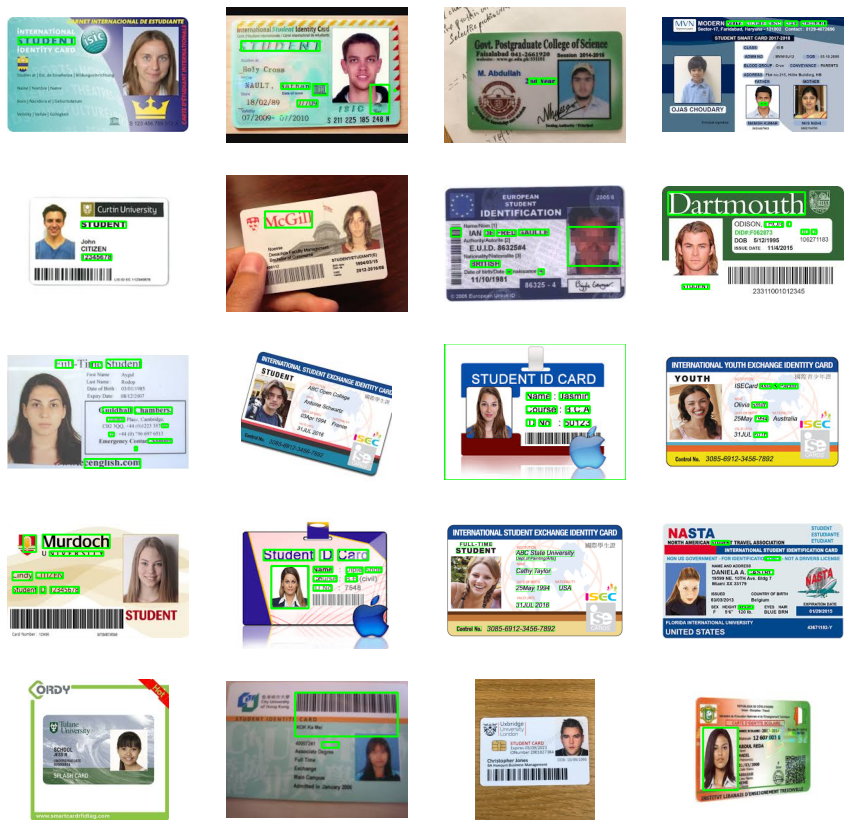

In [26]:
Tesser_dict = {}
img_dict = {}
plt.figure(figsize=(15, 15))

for idx, path in enumerate(images_path):    
    name, cropped_image_path_list, imgs = crop_word_regions(path, output_path)
    Tesser_dict[name] = cropped_image_path_list
    img_dict[name] = imgs
    plt.subplot(5, 4, idx+1)
    plt.imshow(imgs)
    plt.axis('off')

세 번째로 사용해본 기술은 구글의 테서랙트(Tesseract) 라이브러리이다. 테서랙트는 구글에서 후원하는 OCR 오픈소스 라이브러리로 많은 곳에서 사용되고 있다. 특이한 점은 한국어를 포함한 116개 국어를 지원하고 있다는 점이다.  

<br> 
검출 결과는 앞선 모델보다 성능이 떨어져 보인다. Page segmentation modes중에서 3번(Default)보다 11번(Sparse text) 모델이 성능이 좋아서 바꿔보았지만, 잘 Detect를 하지 못했다. 하지만 한국어로 인식을 해야 될때 고려할만한 모델이다. 

In [70]:
def recognize_images(cropped_image_path_list):
    test = []
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pt.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        test.append(recognized_data['text'].replace('\n', '').replace('\x0c',''))
        
    print(test)
    print("Done")

## 텍스트 정확도 비교

['Curtin UniversitySTUDENTJohnCITIZEN12345678', 'Curtin', 'University', 'STUDENT', 'John', 'CITIZEN', '12345678']


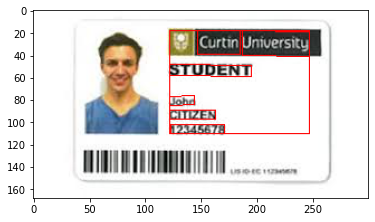

In [67]:
print(ocr_dict['Student_18'])
plt.imshow(ocr_img[4])

AxesSubplot(0.125,0.125;0.775x0.755)


<Figure size 7200x7200 with 0 Axes>

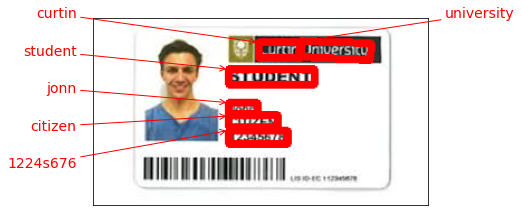

In [66]:
plt.figure(figsize=(100, 100))
a = keras_ocr.tools.drawAnnotations(image=images[4], 
                                    predictions=predictions[4][0])
print(a)

['StUDENT', 'CITLZEN', '12345678', 'a', 'PI']
Done


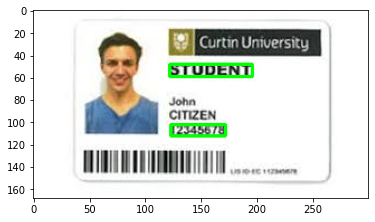

In [71]:
plt.imshow(img_dict['Student_18'])
# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(Tesser_dict['Student_18'])

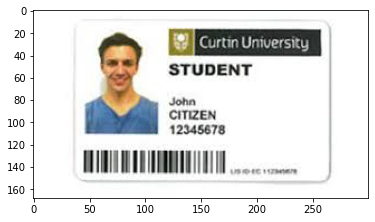

In [72]:
image = img.imread('/home/aiffel0042/aiffel/ocr_python/card/Student_18.jpeg')
plt.imshow(image)

여러가지 이미지 중 임의로 한개의 이미지를 골라서 비교해보았다. 위의 이미지가 윈본이라고 할 때 텍스트를 비교해보자. 
- 원본 이미지: ['Curtin', 'STUDENT', 'CITIZEN', 'University', 'John', '12345678' ]
- OCR API: ['Curtin','STUDENT','CITIZEN', 'University', 'John', '12345678']
- keras-ocr: [curtin, student, citizen,  university,  jonn,  1224s676 ]
- Tesseract:['StUDENT', 'CITLZEN', '12345678', 'a', 'PI']

원본 이미지에 비해 OCR API는 대략 100%, keras-ocr은 70%, Tesseract는 50% 정도의 성능을 보여준다. 
만약 위의 세가지 모델 중에서 OCR 서비스에 적용해야 된다고 한다면 구글의 OCR API를 도입할 것이다. 정확도 뿐만 아니라 대소문자 구분까지 완벽하기 때문이다.  